In [0]:
from google.colab import drive

drive.mount('/content/drive')

In [2]:
#importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

#We have to change the path of the file according to our own.
#This dataset is currently imported from my drive.

dataset = pd.read_csv('/content/drive/My Drive/Datasets/Admission_Predict_Ver1.1.csv')    

dataset.head(10)

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65
5,6,330,115,5,4.5,3.0,9.34,1,0.90
6,7,321,109,3,3.0,4.0,8.20,1,0.75
7,8,308,101,2,3.0,4.0,7.90,0,0.68
8,9,302,102,1,2.0,1.5,8.00,0,0.50
9,10,323,108,3,3.5,3.0,8.60,0,0.45


In [3]:
dataset.info()
dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
Serial No.           500 non-null int64
GRE Score            500 non-null int64
TOEFL Score          500 non-null int64
University Rating    500 non-null int64
SOP                  500 non-null float64
LOR                  500 non-null float64
CGPA                 500 non-null float64
Research             500 non-null int64
Chance of Admit      500 non-null float64
dtypes: float64(4), int64(5)
memory usage: 35.2 KB


,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,250.500000,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,144.481833,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,125.750000,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,250.500000,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,375.250000,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,500.000000,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


In [0]:
#separating the target variable and features
chance_of_admit = dataset['Chance of Admit '].values
features = dataset.drop(dataset.columns[[0,8]], axis = 1).values

dataset = dataset.drop(dataset.columns[0], axis = 1)

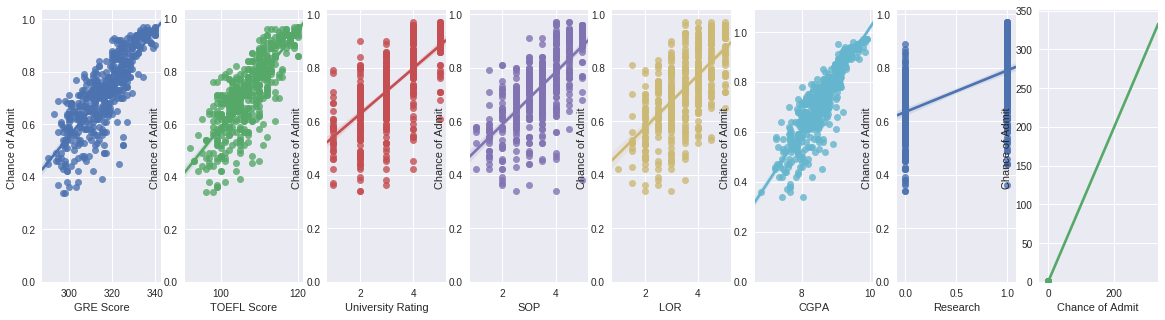

In [5]:
#Visualizing the relation of each feature w.r.to chance of admit
fig, axs = plt.subplots(ncols=8,figsize=(20,5))

for i, var in enumerate(dataset.columns):
    lm = sns.regplot(dataset[var], dataset['Chance of Admit '], ax = axs[i])
    lm.set(ylim=(0, None))


We see that the most of the features are highly correlated with the target variable.

Ref :** Feature_Target_Relation_Plots.png**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa976f3ef98>],
      dtype=object)

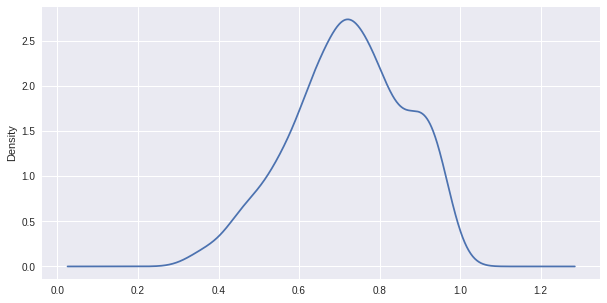

In [6]:
dataset['Chance of Admit '].plot(kind = 'density', subplots = True, figsize =(10, 5))

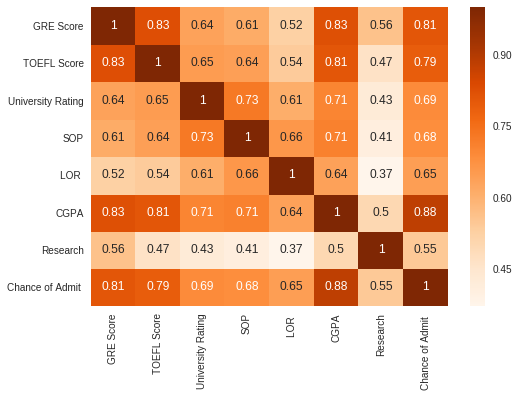

In [7]:
sns.heatmap(dataset.corr(), annot = True, cmap = 'Oranges')

We see that GRE score, CGPA and TOEFL score are highly correlated with the Chance of Admit. CGPA is having the highest correlation to it.
The Research has the least correlation with the chance of admit. We can take a closer look on this in another way, since it is the only categorical variable.

Ref: **Correlation_Heatmap.png**

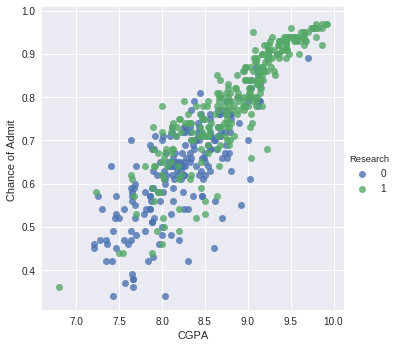

In [8]:
sns.lmplot(y= 'Chance of Admit ', x= 'CGPA', data= dataset, hue = 'Research', fit_reg = False)

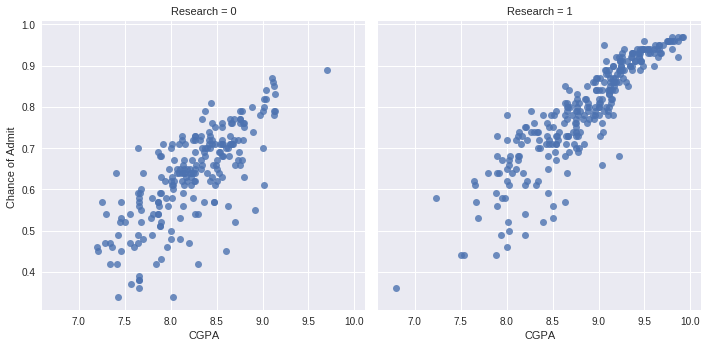

In [9]:
sns.lmplot(y= 'Chance of Admit ', x= 'CGPA', data= dataset, col = 'Research', fit_reg = False)

The above plots show the effect of having done Research by candidates on the potential chance of getting admit. Those having Research have higher chance of getting admit than those not having Research.
The points between CGPA from 8.5 to 10.0 clearly tells us that with research, more number of candidates have higher chance of admit(>0.7) and less number of students have higher chance of admit without having done research.

Ref: **Research_Relation.png**

In [0]:
#Splitting the train and test data
features_train, features_test, chance_train, chance_test = train_test_split(features, chance_of_admit, \
                                                                            test_size = 0.2, random_state = 0)

#Preprocessing of data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)


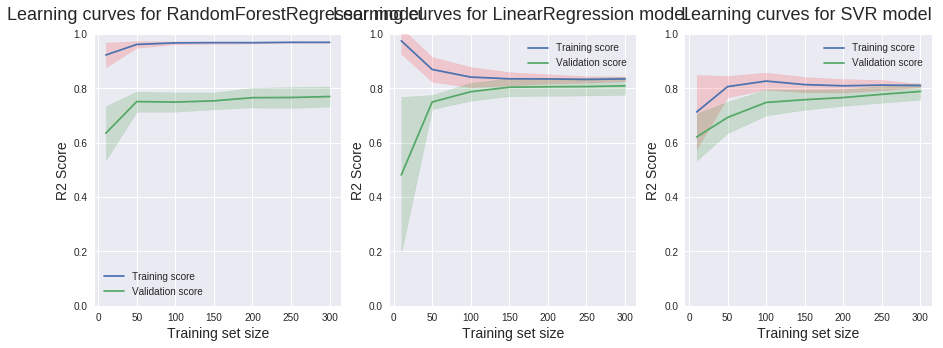

In [11]:
#produce learning curves for varying training set sizes
train_sizes = [10, 50, 100, 150, 200, 250, 300]

#plot the learning curves using r2 score
plt.style.use('seaborn')

#Function for plotting the Learning Curves 
def learning_curves(estimator, features, target, train_sizes, cv, string):
    
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)
    train_sizes, train_scores, validation_scores = learning_curve(estimator, features, target,\
                                                                  train_sizes = train_sizes, cv = cv,\
                                                                  scoring = 'r2', shuffle = True)
    train_scores_std = np.std(train_scores, axis = 1)
    train_scores_mean = np.mean(train_scores, axis = 1)
    validation_scores_std = np.std(validation_scores, axis = 1)
    validation_scores_mean = np.mean(validation_scores, axis = 1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training score')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation score')

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, \
                    train_scores_mean + train_scores_std, alpha = 0.15, color = 'r')
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, \
                    validation_scores_mean + validation_scores_std, alpha = 0.15, color = 'g')
        
    plt.ylabel('R2 Score', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for ' + str(estimator).split('(')[0] + ' model '+ string
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(0,1)
    
    return train_scores_mean, validation_scores_mean

#plotting for multiple models
plt.figure(figsize = (15,5))
for model, i in [(RandomForestRegressor(n_estimators = 100), 1), (LinearRegression(),2), (SVR(kernel = 'linear'), 3)]:
    plt.subplot(1,3,i)
    train_scores_mean, validation_scores_mean = learning_curves(model, features_train, chance_train, train_sizes, 10, '')



From above plots, we decide to use Linear Regression first.
Since Random Forest regressor shows high variance, adding more data won't do any good. In that case, we need to have more complex model, which we will see later by tuning the hyperparameters.

Ref: **Learning_Curves_Regr.png**

In [12]:
#finding best parameters for linear regression using GriSearchCV
param_grid = {'fit_intercept': [True, False], 'normalize': [True, False]}
grid = GridSearchCV(estimator = LinearRegression(), param_grid = param_grid, cv = 10)
grid.fit(features_train, chance_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'fit_intercept': [True, False], 'normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [13]:
grid.best_params_

{'fit_intercept': True, 'normalize': True}

Grid search has given best parameters to use for linear regressor.
We'll now fit the model for these paraameters.

In [14]:
#applying the Linear Regressor with given best params by Grid Search
regressor = LinearRegression(fit_intercept = True, normalize = True)
#regressor = RandomForestRegressor(n_estimators = 300, max_depth = 5)

regressor.fit(features_train, chance_train)

#predicting the chances
chance_predicted = regressor.predict(features_test)

score_lin_reg = r2_score(chance_test, chance_predicted)

print('The r2 score of the model is ', score_lin_reg)


The r2 score of the model is  0.7664048993199384


The r2 score of the model is  0.7664048993199384 in case of Linear Regression.

Let's try other regression models.

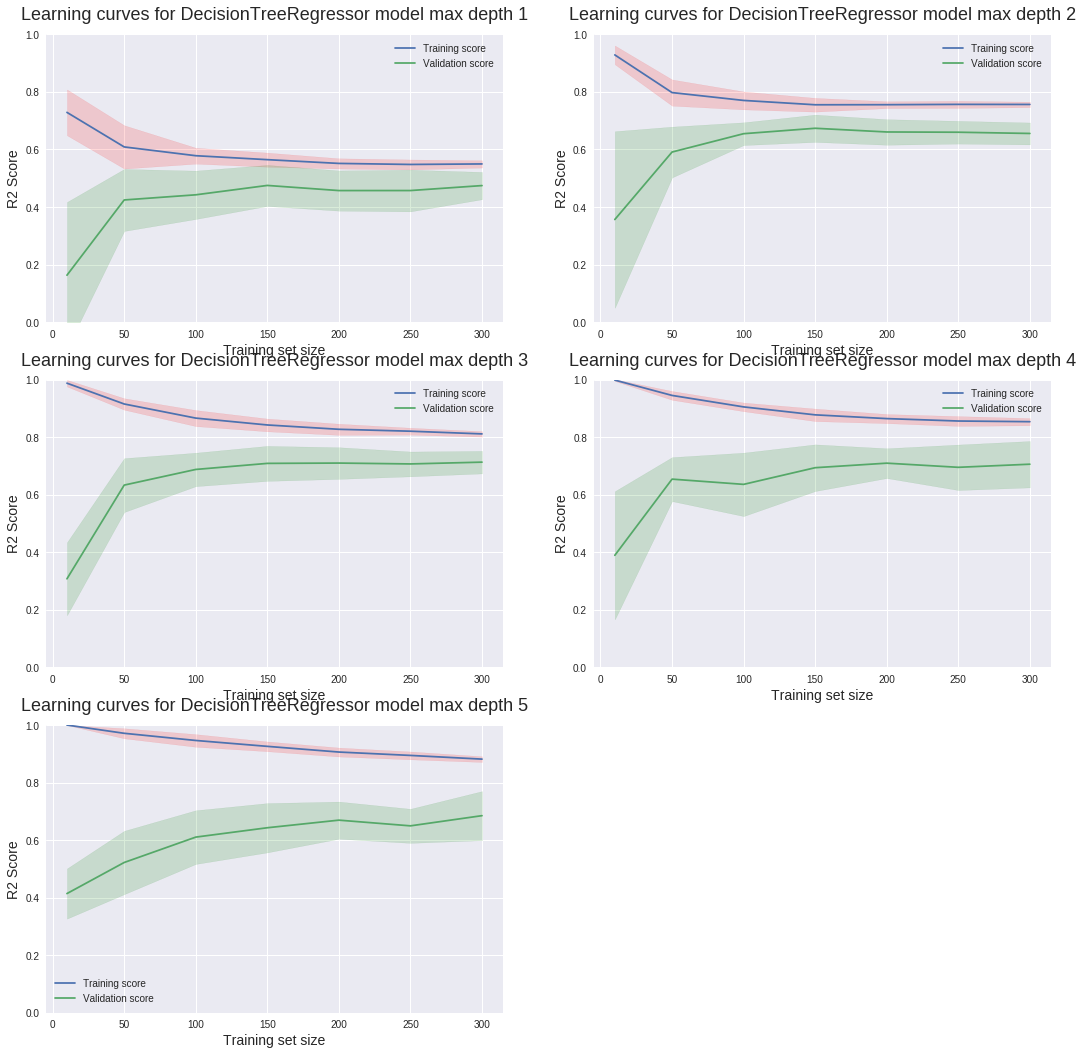

In [15]:
#Lets examine the learning curve of Decision Tree Regressor
plt.figure(figsize = (18,18))
for i, depth in enumerate(np.arange(1, 6)):
    plt.subplot(321+ i)
    train_scores_mean, validation_scores_mean = learning_curves(DecisionTreeRegressor(max_depth = depth), features_train, chance_train, train_sizes, 10, 'max depth '+str(depth))
plt.show()


Ref: **Learning_Curves_Decision_Tree_depth.png**

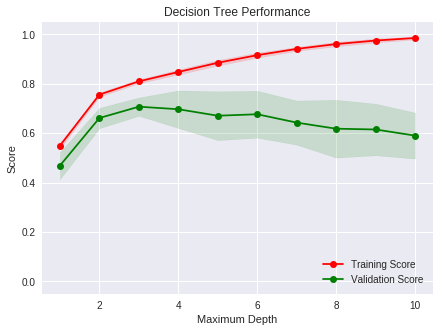

In [16]:
#validation Curve for random forest regressor
#Complexity Curves as a function of hyperparameters values
def ModelComplexity(X, y):
    """ Calculates the performance of the model as model complexity increases.
        The learning and testing errors rates are then plotted. """

    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)

    # Vary the max_depth parameter from 1 to 10
    max_depth = np.arange(1,11)

    # Calculate the training and testing scores
    train_scores, test_scores = validation_curve(DecisionTreeRegressor(), X, y, \
        param_name = "max_depth", param_range = max_depth, cv = cv, scoring = 'r2')

    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    plt.figure(figsize=(7, 5))
    plt.title('Decision Tree Performance')
    plt.plot(max_depth, train_mean, 'o-', color = 'r', label = 'Training Score')
    plt.plot(max_depth, test_mean, 'o-', color = 'g', label = 'Validation Score')
    plt.fill_between(max_depth, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    plt.fill_between(max_depth, test_mean - test_std, \
        test_mean + test_std, alpha = 0.15, color = 'g')

    # Visual aesthetics
    plt.legend(loc = 'lower right')
    plt.xlabel('Maximum Depth')
    plt.ylabel('Score')
    plt.ylim([-0.05,1.05])
    plt.show()
    
ModelComplexity(features_train, chance_train)

Above Learning Curves as well as the Complexity Curve for decision trees show that Max depth of 3 is comparably optimal. We will build the model with it.

Ref: **Decision_Tree_Validation_Curve.png**

In [17]:
regressor = DecisionTreeRegressor(max_depth = 3)

regressor.fit(features_train, chance_train)

#predicting the chances
chance_predicted = regressor.predict(features_test)

score_tree_reg = r2_score(chance_test, chance_predicted)

print('The r2 score of the model is ', score_tree_reg)


The r2 score of the model is  0.7221704903848474


The r2 score of the model is  0.7221704903848474.

Let's try SVM by finding best parameters for it.

In [24]:
#finding best parameters for SVR using GriSearchCV
param_grid = {'kernel': ['linear', 'rbf', 'sigmoid', 'poly'], 'C': [1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.2, 2.4], 'epsilon': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]}
grid = GridSearchCV(estimator = SVR(), param_grid = param_grid, cv = 10)
grid.fit(features_train, chance_train)
grid.best_params_

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

{'C': 1.7, 'epsilon': 0.1, 'kernel': 'linear'}

The grid search tells us about the best parameters are
C: 1.7, kernel: linear and epsilon: 0.1.
Let's build the model.

In [23]:

regressor = SVR(kernel = 'linear', C = 1.7, epsilon = 0.1)

regressor.fit(features_train, chance_train)

#predicting the chances
chance_predicted = regressor.predict(features_test)

score_svr = r2_score(chance_test, chance_predicted)

print('The r2 score of the model is ', score_svr)


The r2 score of the model is  0.7352385397301151


The r2 score of the model is  0.7352385397301151 for SVR.

Let;s try the Random Forest regressor.

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

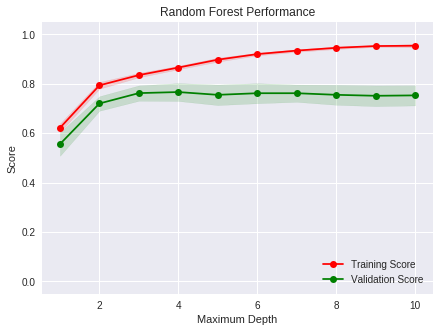

In [25]:
#validation Curve for random forest regressor
#Complexity Curves as a function of hyperparameters values
def ModelComplexity(X, y):
    """ Calculates the performance of the model as model complexity increases.
        The learning and testing errors rates are then plotted. """

    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)

    # Vary the max_depth parameter from 1 to 10
    max_depth = np.arange(1,11)

    # Calculate the training and testing scores
    train_scores, test_scores = validation_curve(RandomForestRegressor(), X, y, \
        param_name = "max_depth", param_range = max_depth, cv = cv, scoring = 'r2')

    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    plt.figure(figsize=(7, 5))
    plt.title('Random Forest Performance')
    plt.plot(max_depth, train_mean, 'o-', color = 'r', label = 'Training Score')
    plt.plot(max_depth, test_mean, 'o-', color = 'g', label = 'Validation Score')
    plt.fill_between(max_depth, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    plt.fill_between(max_depth, test_mean - test_std, \
        test_mean + test_std, alpha = 0.15, color = 'g')

    # Visual aesthetics
    plt.legend(loc = 'lower right')
    plt.xlabel('Maximum Depth')
    plt.ylabel('Score')
    plt.ylim([-0.05,1.05])
    plt.show()
    
ModelComplexity(features_train, chance_train)

It shows the max depth of 4 as optimal. Let's find other parameters as well by Grid Search.

Ref: **Random_Foresr_Reg_Validation_Curve.png**

In [26]:
#finding best parameters for Random Forest Regressor using GriSearchCV
param_grid_RFR = {'n_estimators': [30, 40, 50, 60, 70], 'max_depth':[2, 3, 4, 5, 6, 7, 8, 9]}
grid = GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_grid_RFR, cv = 10)
grid.fit(features_train, chance_train)
grid.best_params_

{'max_depth': 4, 'n_estimators': 60}

It says that RFR needs 60 estimators with max depth of 4. let's build the model and see.

In [28]:
regressor = RandomForestRegressor(n_estimators = 60, max_depth = 4)

regressor.fit(features_train, chance_train)

#predicting the chances
chance_predicted = regressor.predict(features_test)

score_rfr = r2_score(chance_test, chance_predicted)

print('The r2 score of the model is ', score_rfr)

The r2 score of the model is  0.7707444345133936


The r2 score of the model is 0.7707444345133936 for RFR.

We'll now Try Classification models.

We have to convert the target variable to categorical type for classification purpose.
For this, we'll say if the Chance of Admit is < 0.80 it is 0 and 1 if Chance of Admit is > 0.80.

In [0]:
chance_train = [1 if each > 0.8 else 0 for each in chance_train]
chance_test = [1 if each > 0.8 else 0 for each in chance_test]

precision score:  0.9130434782608695
recall score:  0.9545454545454546
f1 score:  0.9333333333333332


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


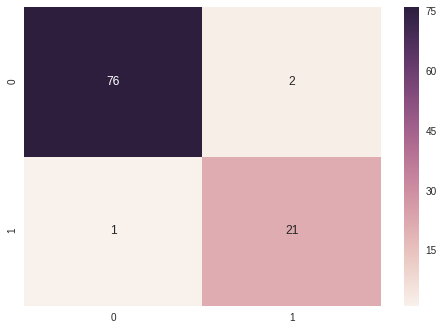

In [30]:
#building Logistic Regression model
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

clf.fit(features_train, chance_train)

chance_predicted = clf.predict(features_test)

#confusion matrix
from sklearn.metrics import confusion_matrix
cm_lr = confusion_matrix(chance_test, chance_predicted)

#visualizing CM
sns.heatmap(cm_lr, annot = True)

#other metrics
from sklearn.metrics import precision_score, recall_score, f1_score

print('precision score: ', precision_score(chance_test, chance_predicted))

print('recall score: ', recall_score(chance_test, chance_predicted))
f1_log_reg = f1_score(chance_test, chance_predicted)
print('f1 score: ', f1_log_reg)

Log Regression scores are as follows:
Cm_lr: [[76,  2], [1, 21]]

precision score:  0.9130434782608695

recall score:  0.9545454545454546

f1 score:  0.9333333333333332

We'll now try SVM.

In [31]:
from sklearn.svm import SVC
#finding best parameters for SVC using GriSearchCV
param_grid_svc = {'kernel': ['linear', 'rbf', 'sigmoid', 'poly'], 'C': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0], 'degree': [2, 3, 4, 5, 6]}
#params = {'C': [1.6, 1.8, 2.0, 2.2, 2.4]}
grid_svc = GridSearchCV(estimator = SVC(), param_grid = param_grid_svc, cv = 10)
grid_svc.fit(features_train, chance_train)
grid_svc.best_params_

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

{'C': 1.0, 'degree': 3, 'kernel': 'poly'}

best params for SVC are: {'C': 1.0, 'degree': 3, 'kernel': 'poly'}

precision score:  0.9523809523809523
recall score:  0.9090909090909091
f1 score:  0.9302325581395349


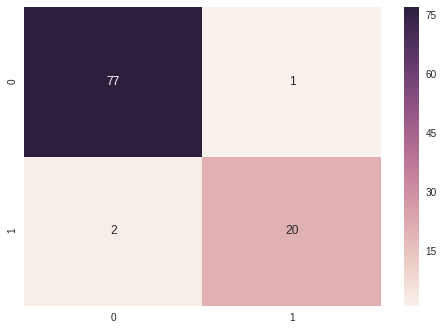

In [32]:
#applying the SVC with the given params

clf_svc = SVC(kernel = 'poly')

clf_svc.fit(features_train, chance_train)

chance_predicted_svc = clf_svc.predict(features_test)

#confusion matrix
cm_svc = confusion_matrix(chance_test, chance_predicted_svc)

#visualizing CM
sns.heatmap(cm_svc, annot = True)

#other metrics
from sklearn.metrics import precision_score, recall_score, f1_score

print('precision score: ', precision_score(chance_test, chance_predicted_svc))

print('recall score: ', recall_score(chance_test, chance_predicted_svc))
f1_svc = f1_score(chance_test, chance_predicted_svc)
print('f1 score: ', f1_svc)

cm_svc: [[77, 1], [2, 20]]

precision score:  0.9523809523809523

recall score:  0.9090909090909091

f1 score:  0.9302325581395349

precision score:  0.8461538461538461
recall score:  1.0
f1 score:  0.9166666666666666


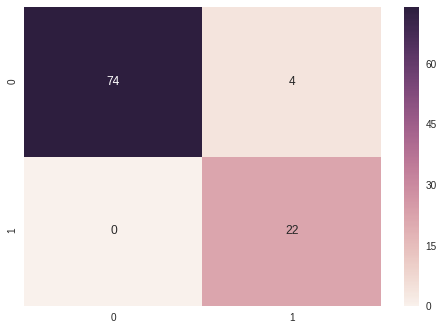

In [33]:
from sklearn.naive_bayes import GaussianNB

clf_nb = GaussianNB()

clf_nb.fit(features_train, chance_train)

chance_predicted_nb = clf_nb.predict(features_test)

#confusion matrix
cm_nb = confusion_matrix(chance_test, chance_predicted_nb)

#visualizing CM
sns.heatmap(cm_nb, annot = True)

#other metrics
print('precision score: ', precision_score(chance_test, chance_predicted_nb))

print('recall score: ', recall_score(chance_test, chance_predicted_nb))
f1_nb = f1_score(chance_test, chance_predicted_nb)
print('f1 score: ', f1_nb)

cm_nb: [[74, 4], [0, 22]]

precision score:  0.8461538461538461

recall score:  1.0

f1 score:  0.9166666666666666

precision score:  0.8695652173913043
recall score:  0.9090909090909091
f1 score:  0.888888888888889


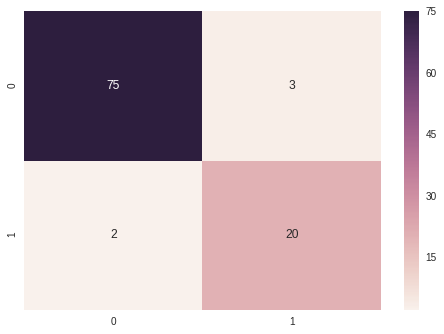

In [34]:
from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier()

clf_tree.fit(features_train, chance_train)

chance_predicted_tree = clf_tree.predict(features_test)

#confusion matrix
cm_tree = confusion_matrix(chance_test, chance_predicted_tree)

#visualizing CM
sns.heatmap(cm_tree, annot = True)

#other metrics
print('precision score: ', precision_score(chance_test, chance_predicted_tree))

print('recall score: ', recall_score(chance_test, chance_predicted_tree))
f1_tree_clf = f1_score(chance_test, chance_predicted_tree)
print('f1 score: ', f1_tree_clf)


cm_tree: [[75, 3], [2, 20]]

precision score:  0.8695652173913043

recall score:  0.9090909090909091

f1 score:  0.888888888888889

precision score:  0.8695652173913043
recall score:  0.9090909090909091
f1 score:  0.888888888888889


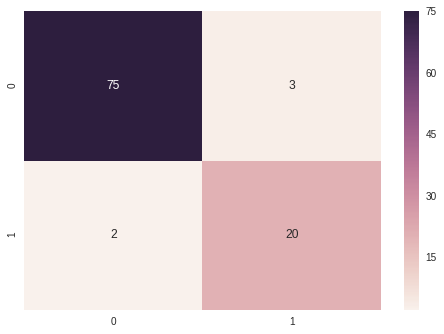

In [35]:
from sklearn.ensemble import RandomForestClassifier

clf_rfc = DecisionTreeClassifier()

clf_rfc.fit(features_train, chance_train)

chance_predicted_rfc = clf_rfc.predict(features_test)

#confusion matrix
cm_rfc = confusion_matrix(chance_test, chance_predicted_rfc)

#visualizing CM
sns.heatmap(cm_rfc, annot = True)

#other metrics
print('precision score: ', precision_score(chance_test, chance_predicted_rfc))

print('recall score: ', recall_score(chance_test, chance_predicted_rfc))
f1_rfc = f1_score(chance_test, chance_predicted_rfc)
print('f1 score: ', f1_rfc)


cm_rfc: [[75, 3], [2, 20]]

precision score:  0.8695652173913043

recall score:  0.9090909090909091

f1 score:  0.888888888888889

In [36]:
clf_rfc.feature_importances_

array([0.1229059 , 0.04187802, 0.01371882, 0.02638889, 0.03534801,
       0.74806219, 0.01169816])

The above array is comprised of the Feature importances we got from Random Forest classifier.

It tells that change in CGPA is highly affecting the  target result i.e. Chance of Admit, GRE score is the second one and so on.

precision score:  0.9
recall score:  0.8181818181818182
f1 score:  0.8571428571428572


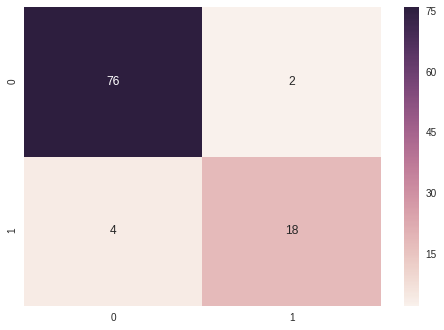

In [38]:
clf_knn = KNeighborsClassifier()
clf_knn.fit(features_train, chance_train)

chance_predicted_knn = clf_knn.predict(features_test)

#confusion matrix
cm_knn = confusion_matrix(chance_test, chance_predicted_knn)

#visualizing CM
sns.heatmap(cm_knn, annot = True)

#other metrics
print('precision score: ', precision_score(chance_test, chance_predicted_knn))

print('recall score: ', recall_score(chance_test, chance_predicted_knn))
f1_knn = f1_score(chance_test, chance_predicted_knn)
print('f1 score: ', f1_knn)


KNN gives precision score:  0.9

recall score:  0.8181818181818182

f1 score:  0.8571428571428572

Finally we compare the performances of all the algorithms by visualizing the scores through bar graphs. 

For regressors, r2 score is calculated as an accuracy measure, while f1 score is used for the same purpose in case of classifiers.

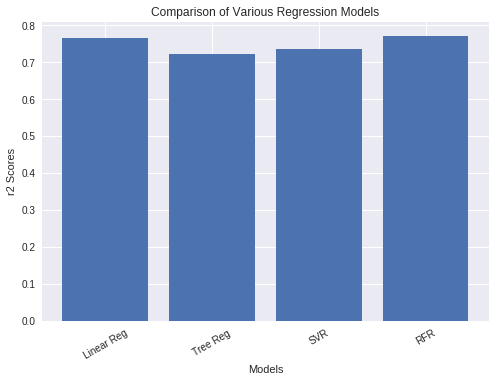

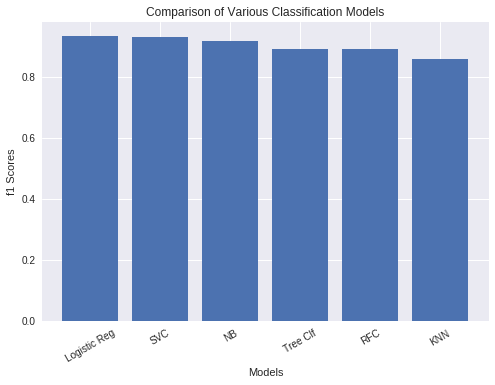

In [39]:
#preparing the list of labels and variables for the axes
reg_labels = ['Linear Reg', 'Tree Reg', 'SVR', 'RFR']
clf_labels = ['Logistic Reg', 'SVC', 'NB', 'Tree Clf', 'RFC', 'KNN']

reg_scores = [score_lin_reg, score_tree_reg, score_svr, score_rfr]
clf_scores = [f1_log_reg, f1_svc, f1_nb, f1_tree_clf, f1_rfc, f1_knn]

#visualizing the regressors scores
index = np.arange(len(reg_labels))
plt.bar(index, reg_scores)
plt.xlabel('Models')
plt.ylabel('r2 Scores')
plt.xticks(index, reg_labels, rotation = 30)
plt.title('Comparison of Various Regression Models')
plt.show()

#visualizing the classifiers scores
index_clf = np.arange(len(clf_labels))
plt.bar(index_clf, clf_scores)
plt.xlabel('Models')
plt.ylabel('f1 Scores')
plt.xticks(index_clf, clf_labels, rotation = 30)
plt.title('Comparison of Various Classification Models')
plt.show()


The graph of regressors shows that the Random forest and Linear regressors perform comparably well than others.

For classifiers, the graph shows that the Logistic Regressor and Support Vector Classifier worked well.

Ref: **Performance_Comparison.png**